In [1]:
!pip install tensorflow scikit-learn matplotlib

In [2]:
!pip install seaborn

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import zipfile

zip_path = "/content/drive/MyDrive/fish_dataset.zip"  # or use .zip exact path
extract_path = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [5]:
import os
os.listdir("/content/data")


['Image Classification']

In [6]:
os.listdir("/content/data/Image Classification/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/fish_dataset")


['train', 'test', 'val']

In [7]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from sklearn.metrics import classification_report, confusion_matrix

# Dataset paths (based on user unzip structure)
dataset_base = "/content/data/Image Classification/Dataset/images.cv_jzk6llhf18tm3k0kyttxz/fish_dataset"
train_dir = os.path.join(dataset_base, "train")
val_dir = os.path.join(dataset_base, "val")
test_dir = os.path.join(dataset_base, "test")


In [15]:

# Parameters
img_height, img_width = 224, 224
batch_size = 50
epochs = 12


In [9]:
# Image Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20,
                                   zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width),
                                               batch_size=batch_size, class_mode='categorical')

val_data = test_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width),
                                            batch_size=batch_size, class_mode='categorical', shuffle=False)

test_data = test_datagen.flow_from_directory(test_dir, target_size=(img_height, img_width),
                                             batch_size=batch_size, class_mode='categorical', shuffle=False)

num_classes = train_data.num_classes


Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [17]:

# CNN from scratch
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("\nTraining CNN from scratch...")
cnn_history = cnn_model.fit(train_data, epochs=epochs, validation_data=val_data)
cnn_model.save("cnn_fish_model.h5")



Training CNN from scratch...
Epoch 1/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 637ms/step - accuracy: 0.2674 - loss: 2.9712 - val_accuracy: 0.5723 - val_loss: 1.2267
Epoch 2/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 625ms/step - accuracy: 0.5553 - loss: 1.2615 - val_accuracy: 0.7317 - val_loss: 0.8884
Epoch 3/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 621ms/step - accuracy: 0.6388 - loss: 1.0006 - val_accuracy: 0.8150 - val_loss: 0.6187
Epoch 4/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 605ms/step - accuracy: 0.7422 - loss: 0.7479 - val_accuracy: 0.8672 - val_loss: 0.4450
Epoch 5/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 609ms/step - accuracy: 0.7726 - loss: 0.6558 - val_accuracy: 0.8947 - val_loss: 0.3599
Epoch 6/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 611ms/step - accuracy: 0.8129 - loss: 0.5399 - val_accuracy: 0.9203 - val_loss: 0.3018
Epoch 7/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 603ms/step - accuracy: 0.8234 - loss: 0.5129 - val_accuracy: 0.9176 - val_loss: 0.2856
Epoch 8/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 614ms/ste

In [ ]:

    !cp /content/cnn_fish_model.h5 /content/drive/MyDrive/

In [11]:

# Transfer Learning with ResNet50
print("\nTraining with ResNet50...")
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3), pooling='avg')
base_model.trainable = False

x = base_model.output
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)
resnet_model = Model(inputs=base_model.input, outputs=predictions)

resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet_history = resnet_model.fit(train_data, epochs=epochs, validation_data=val_data)
resnet_model.save("resnet50_fish_model.h5")



Training with ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 107s 746ms/step - accuracy: 0.1444 - loss: 2.3554 - val_accuracy: 0.1575 - val_loss: 2.2144
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 633ms/step - accuracy: 0.1822 - loss: 2.2324 - val_accuracy: 0.1850 - val_loss: 2.1554
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 628ms/step - accuracy: 0.2033 - loss: 2.1598 - val_accuracy: 0.2353 - val_loss: 2.0863
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 632ms/step - accuracy: 0.2458 - loss: 2.1003 - val_accuracy: 0.3288 - val_loss: 2.0237
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 635ms/step - accuracy: 0.2442 - loss: 2.0584 - val_accuracy: 0.2940 - val_loss: 1.9765


In [ ]:

    !cp /content/resnet50_fish_model.h5 /content/drive/MyDrive/

    #/content/resnet50_fish_model.h5

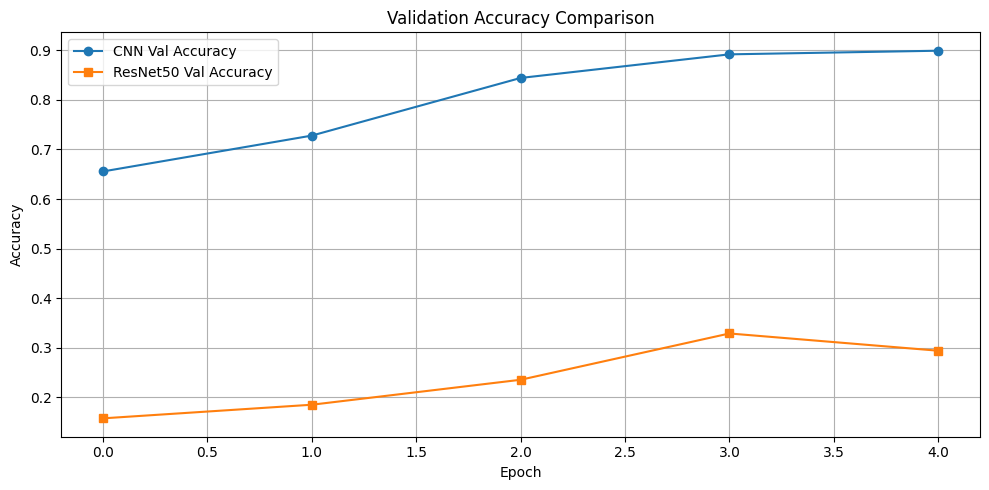

In [14]:
# Make sure this line is in the first cell of your Colab notebook:
%matplotlib inline

# Plot Accuracy Comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val Accuracy', marker='o')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet50 Val Accuracy', marker='s')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)  # Optional: to make it easier to read
plt.tight_layout()  # To avoid cutoff of labels
plt.show()  # Show plot in Colab output


64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.40      0.65      0.50       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.00      0.00      0.00       298
   fish sea_food gilt_head_bream       0.00      0.00      0.00       305
   fish sea_food hourse_mackerel       0.36      0.44      0.39       286
        fish sea_food red_mullet       0.22      0.73      0.34       291
     fish sea_food red_sea_bream       1.00      0.01      0.01       273
          fish sea_food sea_bass       0.00      0.00      0.00       327
            fish sea_food shrimp       0.22      0.18      0.19       289
fish sea_food striped_red_mullet       0.15      0.19      0.17       293
             fish sea_food trout       0.31      0.46      0.37       292

                        accuracy            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


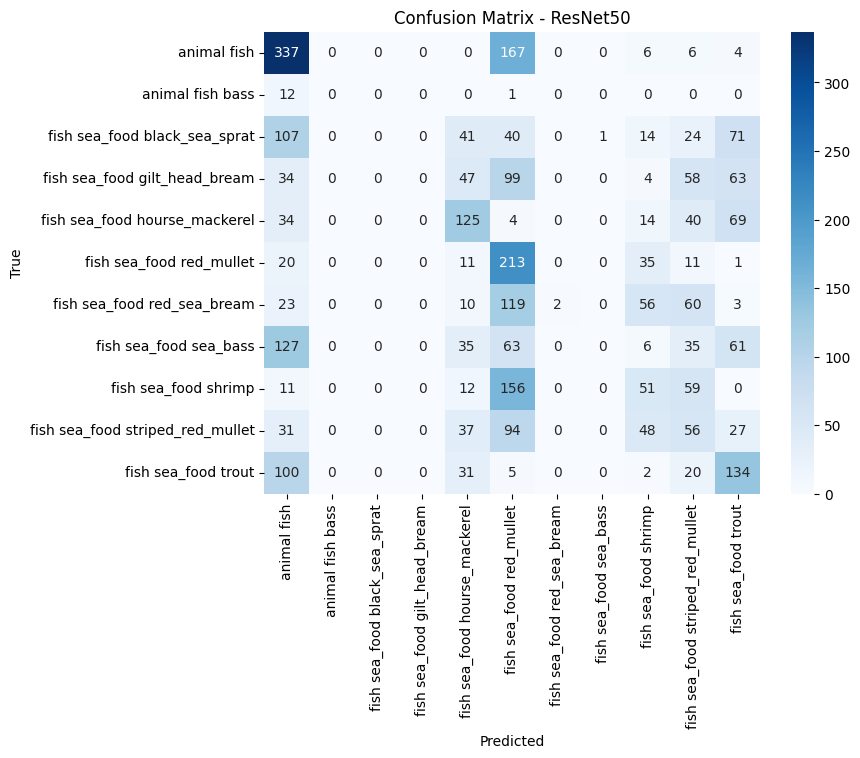


All done! Models and evaluation plots showed.


In [13]:
# Evaluate Best Model (ResNet50) on Test Set
y_pred = resnet_model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(test_data.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet50')
#plt.savefig("confusion_matrix_resnet50.png")
plt.show()
plt.close()

print("\nAll done! Models and evaluation plots showed.")
